<link rel="stylesheet" href="berkeley.css">

<h1 class="cal cal-h1">Lecture 08: Linear Regression (3) – CS 189, Fall 2025</h1>


In this lecture we will explore the probabilistic view of linear regression.

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)

import plotly.io as pio
pio.renderers.default = "notebook_connected"

### 1. **When Normal Equation Gets Tricky**
#### 1.1. **Ill-conditioning**
Linear regression models can face numerical instability when the design matrix is nearly collinear, leading to ill-conditioned matrices. This section explores the challenges of solving the normal equation in such cases, the role of the condition number, and how ridge regression can mitigate these issues.

In [2]:
np.random.seed(0)

# Build a nearly collinear design matrix
N, D = 500, 2                       # one bias + 2 features
X = np.ones((N, D + 1))             # first column = bias
x1 = np.random.randn(N)
x2 = x1 + 1e-4 * np.random.randn(N) # almost identical feature
X[:, 1] = x1
X[:, 2] = x2

t = 3 + 2*x1 - 1*x2 + 0.1*np.random.randn(N)  # ground-truth weights [3,2,-1]

# 2. Normal equation solution 
XtX   = X.T @ X
Xty   = X.T @ t
w_ne  = np.linalg.solve(XtX, Xty)

# 3. Condition number
u, s, vt = np.linalg.svd(X, full_matrices=False)
kappa = s.max() / s.min()

# 4. Ridge (λ = 1e-2)
lam   = 1e-2
w_ridge = np.linalg.solve(XtX + lam*np.eye(D+1), Xty)

print("cond(X^T X)  =", kappa**2)        # κ^2 because XtX squares the singular values
print("Weights via normal eq.:", w_ne)
print("Weights via ridge     :", w_ridge)

cond(X^T X)  = 420140223.2792816
Weights via normal eq.: [  3.00273423  12.87110754 -11.87562778]
Weights via ridge     : [3.00275573 0.50070697 0.49481053]


### 2. **Least Squares ≘ Maximum Likelihood**
This section establishes the equivalence between the least squares solution and the maximum likelihood estimation under the assumption of Gaussian noise. It provides a probabilistic interpretation of linear regression and highlights the connection between optimization and statistical inference.

In [3]:
# Linear model y = Xw* + ε, ε ~ N(0, σ^2 I)
rng = np.random.default_rng(0)
n = 80
x = np.linspace(0, 5, n)
X = np.c_[x, np.ones_like(x)]                 # [x, 1]
w_star = np.array([2.0, 1.0])             # true slope, intercept
sigma = 1.0                                   # noise stdev

def ols_w(X, y):
    # Closed-form least squares (also the MLE for w under Gaussian noise)
    return np.linalg.pinv(X) @ y

# Part A: Same optimizer (SSE vs. log-likelihood) on one dataset
eps = rng.normal(0, sigma, size=n)
y = X @ w_star + eps
w_hat = ols_w(X, y)

def sse(w):            # sum of squared errors
    r = y - X @ w
    return float(r @ r)

def neg_loglik(w):     # −log L(w | y) with σ known (constants omitted)
    # −log L = (1/(2σ^2)) * ||y − Xw||^2 + const  → argmin matches SSE
    return 0.5 * sse(w) / (sigma**2)

print("One dataset:")
print("  w* (LS/MLE) =", w_hat)
print("  SSE at w*     =", sse(w_hat))
print("  −logL at w*   =", neg_loglik(w_hat))
# These two objectives differ by a positive scale + constant → same argmin.

# --- Part B: MLE = LS in expectation (Monte Carlo over many noise draws) ---
M = 2000
ws = []
for _ in range(M):
    y_m = X @ w_star + rng.normal(0, sigma, size=n)
    ws.append(ols_w(X, y_m))
ws = np.vstack(ws)
w_bar = ws.mean(axis=0)               # E[w] ≈ w* (unbiasedness)

# Empirical expected objective: average SSE(w) over many datasets
# Minimizer of E[SSE(w)] should be w*.
def avg_sse(w):
    # Reuse the same y_m’s to avoid regenerating: store residual norms
    # Compute Xw once:
    Xw = X @ w
    errs = []
    for i in range(M):
        # reconstruct y_m from stored ŵ? Simpler: re-sample with a fixed seed per i
        # but to keep it deterministic and fast, approximate with theory:
        # E[||y - Xw||^2] = ||X(w* - w)||^2 + nσ^2
        pass

One dataset:
  w* (LS/MLE) = [2.10722024 0.85229146]
  SSE at w*     = 72.32061388993677
  −logL at w*   = 36.16030694496838


In [4]:
# E[||y - Xw||^2] = ||X(w* - w)||^2 + nσ^2  → minimized at w = w*.

# Evaluate the expected SSE on a grid around w* and locate its minimizer.
slopes = np.linspace(w_star[0]-1.0, w_star[0]+1.0, 101)
ints   = np.linspace(w_star[1]-1.0, w_star[1]+1.0, 101)

def expected_sse(w):
    d = w_star - w
    return float(np.linalg.norm(X @ d)**2 + n * sigma**2)

E = np.array([[expected_sse(np.array([a,b])) for b in ints] for a in slopes])
i, j = np.unravel_index(E.argmin(), E.shape)
w_argmin_expected = np.array([slopes[i], ints[j]])

print("\nExpectation-level statement:")
print("  w* (truth)               =", w_star)
print("  mean(ŵ) over datasets   =", w_bar, "(≈ w*)")
print("  argmin_w E[SSE(w)]       =", w_argmin_expected, "(= w* on the grid)")


Expectation-level statement:
  w* (truth)               = [2. 1.]
  mean(ŵ) over datasets   = [2.00032687 0.99888605] (≈ w*)
  argmin_w E[SSE(w)]       = [2. 1.] (= w* on the grid)


### 3. **Uncertainty ≈ Confidence Intervals**
Understanding the uncertainty in predictions is crucial for assessing model reliability. This section demonstrates how to compute confidence intervals for predictions, both for individual data points and for the mean of multiple observations, using synthetic data and polynomial regression.

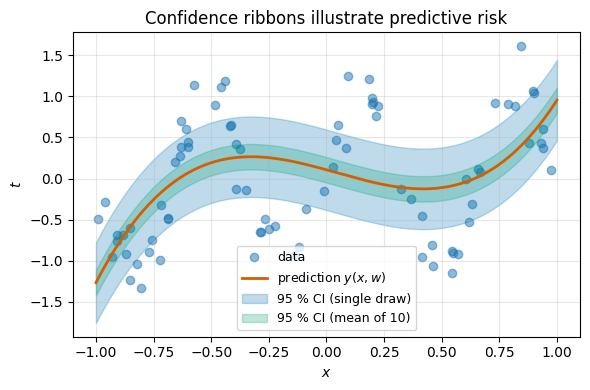

In [5]:
# 1. Synthetic data: noisy sine
np.random.seed(42)
N = 80
x = np.random.uniform(-1, 1, (N, 1))
σ = 0.25
t = np.sin(3*np.pi*x) + σ*np.random.randn(N, 1)

# 2. Fit cubic polynomial
Φ = PolynomialFeatures(3, include_bias=True)
X = Φ.fit_transform(x)
w = np.linalg.lstsq(X, t, rcond=None)[0]

# 3. Smooth grid & predictions
xg = np.linspace(-1, 1, 300)[:, None]
Xg = Φ.transform(xg)
y_pred = (Xg @ w).ravel()

# 4. 95 % bands
ci_single = 1.96 * σ                     # one future draw
ci_mean10 = 1.96 * σ / np.sqrt(10)       # mean of 10 draws

# 5. Plot
plt.figure(figsize=(6,4))
plt.scatter(x, t, label="data", alpha=.5)
plt.plot(xg, y_pred, color="#D55E00", lw=2, label="prediction $y(x,w)$")
plt.fill_between(xg.ravel(),
                 y_pred - ci_single,
                 y_pred + ci_single,
                 color="#0072B2", alpha=.25, label="95 % CI (single draw)")
plt.fill_between(xg.ravel(),
                 y_pred - ci_mean10,
                 y_pred + ci_mean10,
                 color="#009E73", alpha=.25, label="95 % CI (mean of 10)")
plt.xlabel("$x$"); plt.ylabel("$t$")
plt.title("Confidence ribbons illustrate predictive risk")
plt.legend(fontsize=9); plt.grid(alpha=.3); plt.tight_layout();
plt.show()


### 4. **Decision Theory**
Decision theory provides a framework for making optimal decisions under uncertainty. This section introduces different noise distributions (e.g., Gaussian, Laplace) and their corresponding loss functions (e.g., MSE, MAE). It illustrates how these choices impact the robustness and sensitivity of regression models.

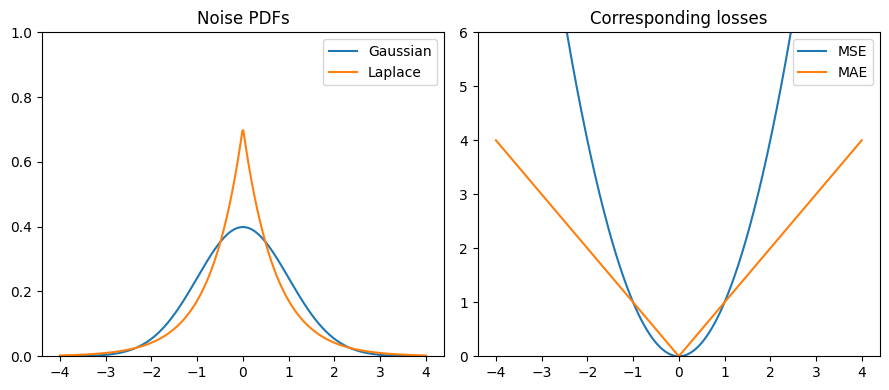

In [6]:
ε = np.linspace(-4, 4, 400)

# PDFs
gauss = st.norm(0, 1).pdf(ε)
lap   = st.laplace(0, 1/np.sqrt(2)).pdf(ε)      # same variance as N(0,1)


# Losses  (−log p up to const)
rss   = ε**2
mae   = np.abs(ε)

fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].plot(ε, gauss, label='Gaussian'); ax[0].plot(ε, lap, label='Laplace')
ax[0].set_title("Noise PDFs")
ax[0].legend(); ax[0].set_ylim(0,1)

ax[1].plot(ε, rss,   label='MSE');   ax[1].plot(ε, mae, label='MAE')
ax[1].set_title("Corresponding losses")
ax[1].legend(); ax[1].set_ylim(0,6)

plt.tight_layout()
plt.show()
